## Import Modules

In [2]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

**os** - used to handle files using system commands.

**pickle** - used to store numpy features extracted

**numpy** - used to perform a wide variety of mathematical operations on arrays

**tqdm** - progress bar decorator for iterators. Includes a default range iterator printing to stderr.

**VGG16, preprocess_input** - imported modules for feature extraction from the image data

**load_img, img_to_array** - used for loading the image and converting the image to a numpy array

**Tokenizer** - used for loading the text as convert them into a token

**pad_sequences** - used for equal distribution of words in sentences filling the remaining spaces with zeros

**plot_model** - used to visualize the architecture of the model through different images

In [3]:
#set the directories to use the data
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

## Load and restructure the model

VGG-16 is a convolutional neural network that is 16 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals.

* Fully connected layer of the VGG16 model is not needed, just the previous layers to extract feature results.

* By preference you may include more layers, but for quicker results avoid adding the unnecessary layers.

In [4]:
# load vgg16 model
model = VGG16()

# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# summarize
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


## Extract Image Features

In [5]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    #load images from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))

    #convert image pixels to numpy array
    image = img_to_array(image)

    #reshape the data for our model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    #preprocess the image for vgg
    image = preprocess_input(image)

    #exract the features
    feature = model.predict(image, verbose=0)

    #get image id
    image_id = img_name.split('.')[0]

    #store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

Dictionary 'features' is created and will be loaded with the extracted features of image data

**load_img(img_path, target_size=(224, 224))** - custom dimension to resize the image when loaded to the array

**image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))** - reshaping the image data to preprocess in a RGB type image.

**model.predict(image, verbose=0)** - extraction of features from the image

**img_name.split('.')[0]** - split of the image name from the extension to load only the image name.

In [7]:
#store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

Extracted features are not stored in the disk, so re-extraction of features can extend running time

Dumps and store your dictionary in a pickle for reloading it to save time

In [8]:
#load features from pickle
#Load all your stored feature data to your project for quicker runtime
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

## Load the Captions Data

Let us store the captions data from the text file

In [9]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

### Split and append the captions data with the image

In [10]:
#create mapping of images to captions
mapping = {}

#process the lines
for line in tqdm(captions_doc.split('\n')):
    #split the line by comma
    tokens = line.split(',')

    if len(line) < 2:
        continue

    image_id, caption = tokens[0], tokens[1:]

    #remove extensions from image_id
    image_id = image_id.split('.')[0]

    #convert caption list into string
    caption = " ".join(caption)

    #create list if needed
    if image_id not in mapping:
        mapping[image_id] = []

    #store the caption
    mapping[image_id].append(caption)


  0%|          | 0/40456 [00:00<?, ?it/s]

*   Dictionary 'mapping' is created with key as image_id and values as the corresponding caption text
*   Same image may have multiple captions, if image_id not in mapping: *mapping[image_id] = [ ]* creates a list for appending captions to the corresponding image

In [11]:
#number of images loaded
len(mapping)

8091

## Preprocess text data

In [12]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            #take one caption at a time
            caption = captions[i]

            #preprocessing steps
            #convert to lower case
            caption = caption.lower()

            #delete digits, spcl chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')

            #delete additional spaces
            caption = caption.replace('\s+', '')

            #add start and end tags to the caption
            caption = 'start ' + " ".join([word for word in caption.split() if len(word)>1]) + ' end'

            captions[i] = caption

Defined to clean and convert the text for quicker process and better results

### Visualize the text before and after cleaning


In [13]:
#before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [14]:
#preprocess of text
clean(mapping)

In [15]:
#after preprocess of text
mapping['1000268201_693b08cb0e']

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end']

In [16]:
#store the preprocessed captions into a list
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [17]:
len(all_captions)

40455

In [18]:
#Let us see the first ten captions
all_captions[:10]

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end',
 'start black dog and spotted dog are fighting end',
 'start black dog and tri-colored dog playing with each other on the road end',
 'start black dog and white dog with brown spots are staring at each other in the street end',
 'start two dogs of different breeds looking at each other on the road end',
 'start two dogs on pavement moving toward each other end']

## Processing of text data

In [19]:
#tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [20]:
#number of unique words
vocab_size

8483

In [21]:
#Finding the maximum length of the caption available, used for reference for the padding sequence.
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Train Test Split

In [22]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [23]:
#let's define a batch and include the padding sequence
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

Padding sequence normalizes the size of all captions to the max size filling them with zeros for better results.

## Model Creation

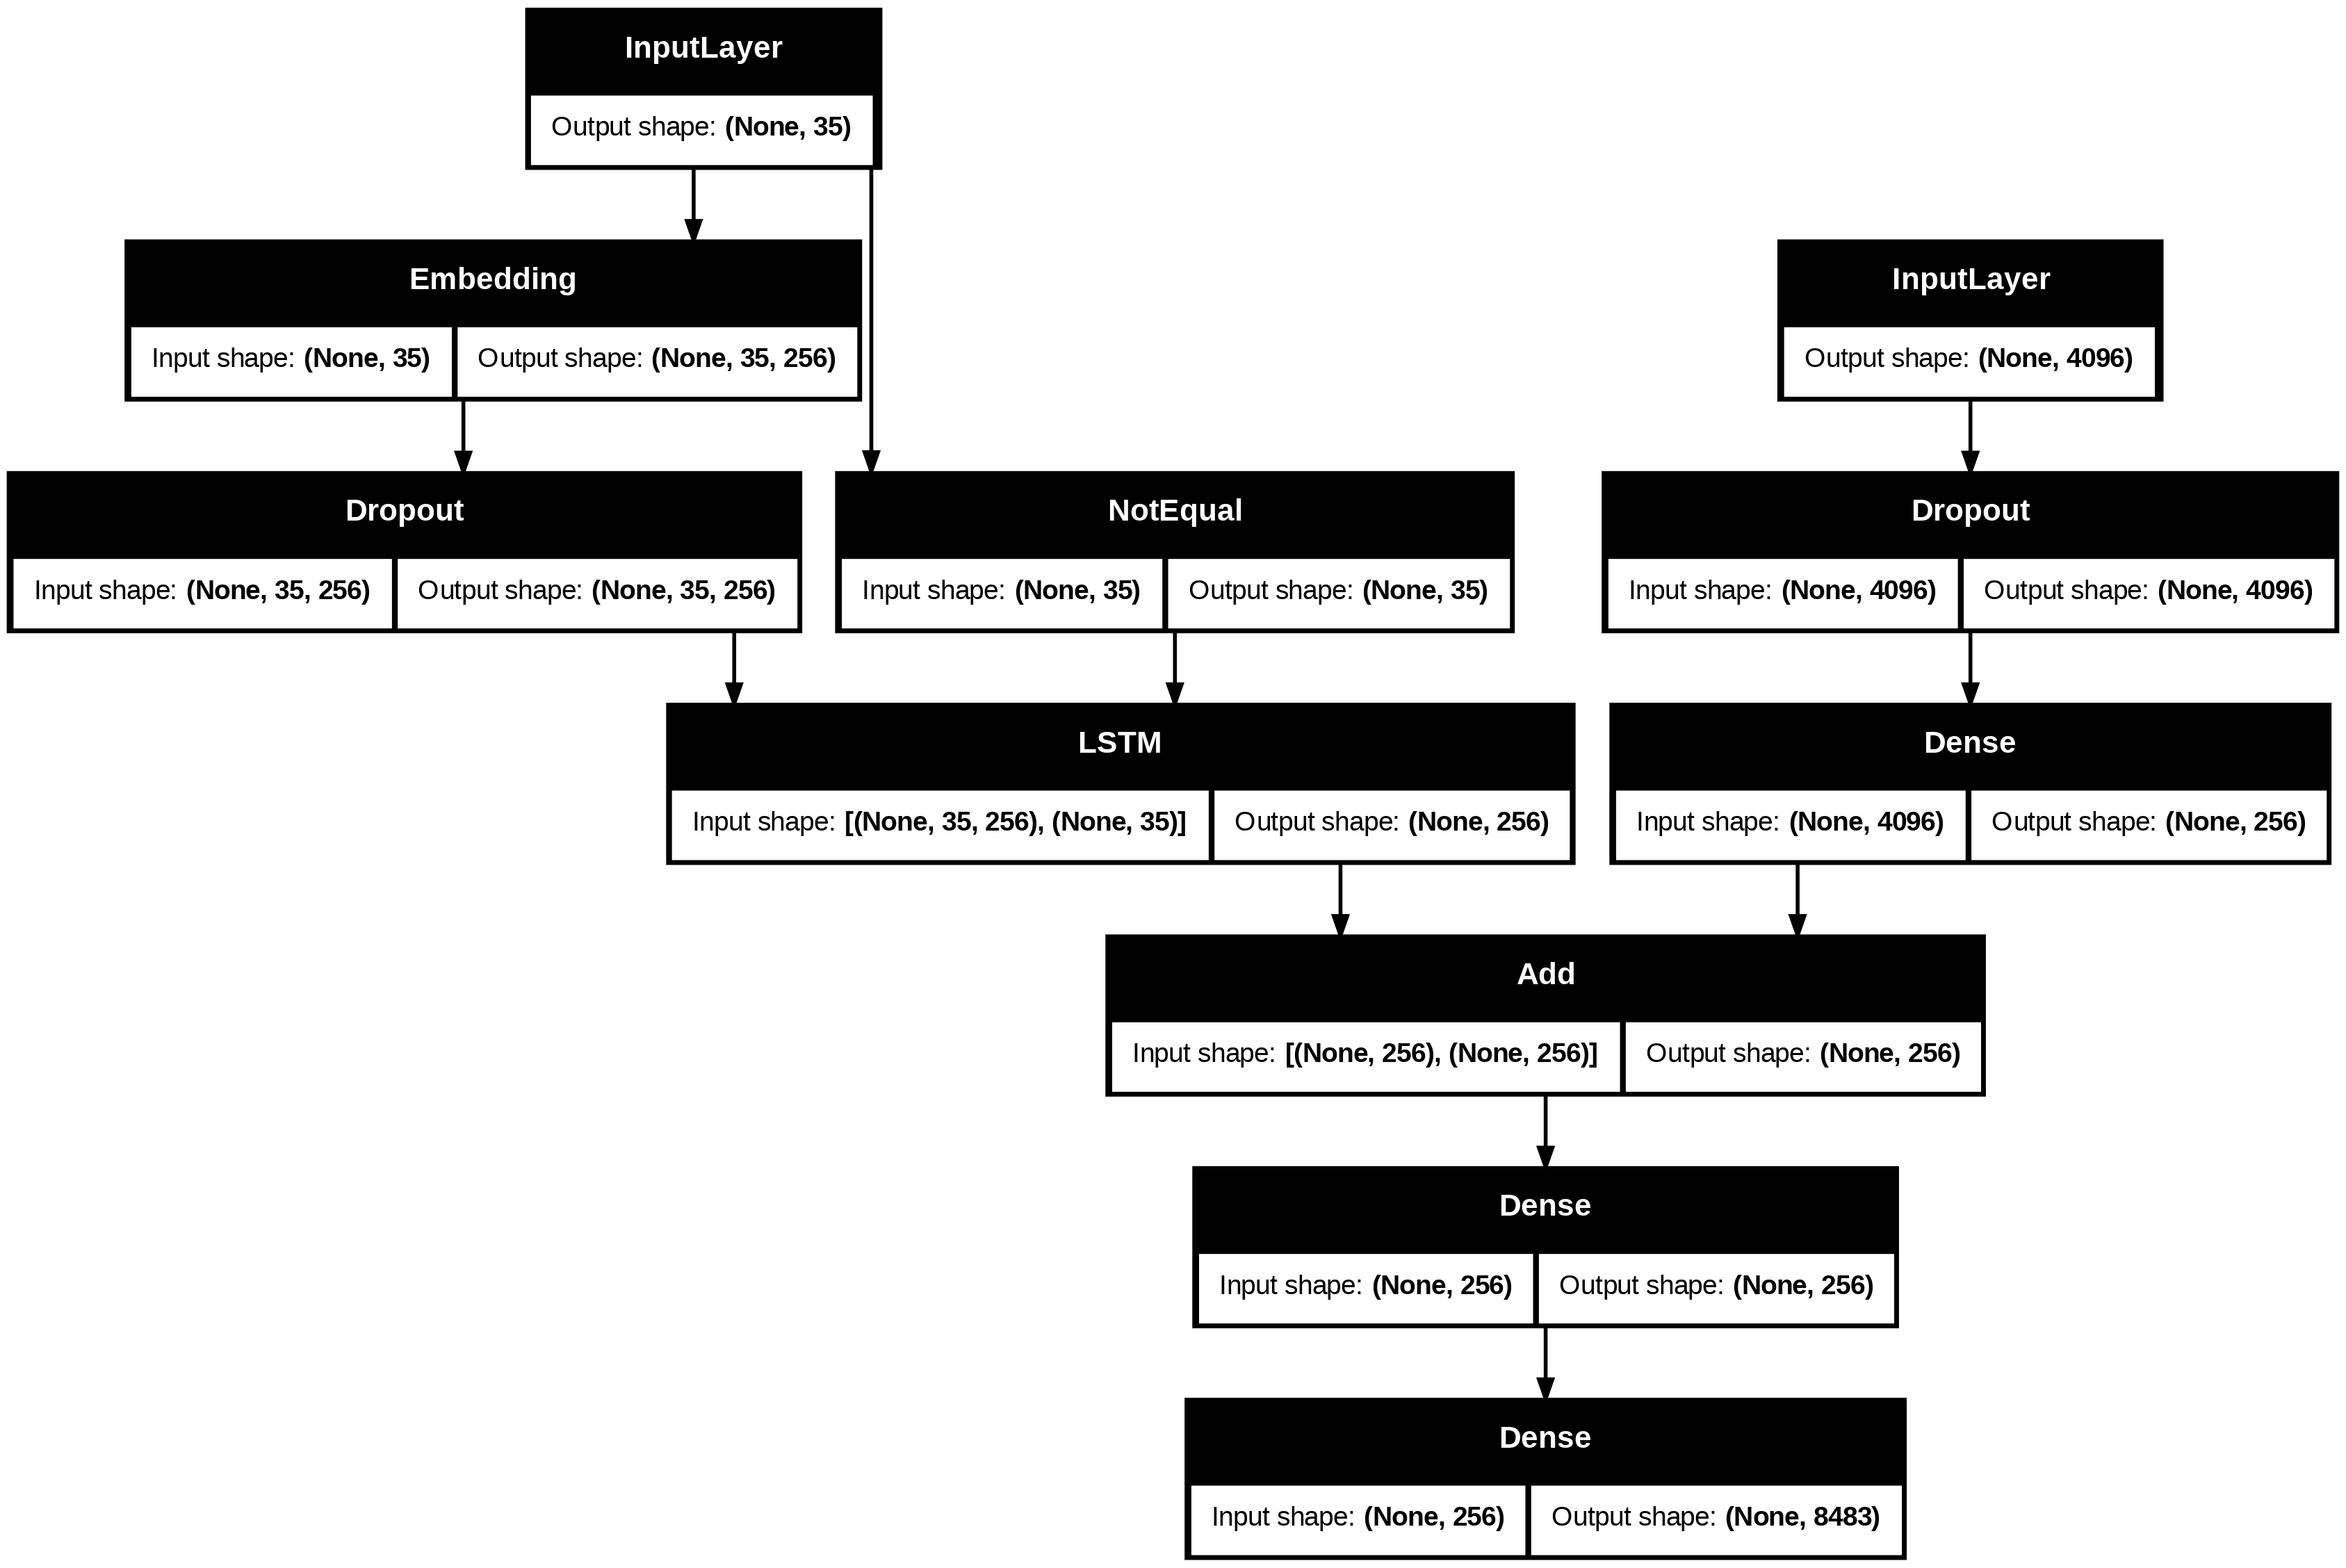

In [24]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

*   **shape=(4096,)** - output length of the features from the VGG model

*   **Dense** - single dimension linear layer array

*   **Dropout()** - used to add regularization to the data, avoiding over fitting & dropping out a fraction of the data from the layers

*   **model.compile()** - compilation of the model


*   **loss=’sparse_categorical_crossentropy’** - loss function for category outputs


*   **optimizer=’adam’** - automatically adjust the learning rate for the model over the no. of epochs


Model plot shows the concatenation of the inputs and outputs into a single layer

Feature extraction of image was already done using VGG, no CNN model was needed in this step.

## Train Model

In [25]:
# train the model
epochs = 25
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)

    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 233ms/step - loss: 5.7842
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 229ms/step - loss: 4.0547
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 229ms/step - loss: 3.5816
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 228ms/step - loss: 3.2992
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 232ms/step - loss: 3.0952
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 230ms/step - loss: 2.9357
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 228ms/step - loss: 2.8129
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 228ms/step - loss: 2.7209
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 227ms/step - loss: 2.6465
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 227ms/step - loss: 2.5797
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 229ms/step - loss: 2.5170
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 229ms/step - loss: 2.4578
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 231ms/step - loss: 2.4090
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 230ms/step - loss: 2.3607
227/227 ━━━━━━━━━━━━━━━━━━━━ 51s 225ms/step - loss: 2.3215
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 228ms/step - loss: 2.2845
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 231ms/step - loss: 2.24

*   **steps = len(train) // batch_size** - back propagation and fetch the next data

*   Loss decreases gradually over the iterations

*   Increase the no. of epochs for better results

*   Assign the no. of epochs and batch size accordingly for quicker results

In [26]:
#save the model in working directory for reuse
model.save(WORKING_DIR + '/best_model.h5')

## Generate captions for the image

In [27]:
#helper function to convert the predicted index from the model into a word
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None



In [28]:
#generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'start'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length, padding='post')
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'end':
            break
    return in_text

The caption starts with 'start' and the model continues to predict the caption until the 'end' appeared

## Model Validation

In [29]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.536892
BLEU-2: 0.309823


* BLEU Score is used to evaluate the predicted text against a reference text, in a list of tokens.

* The reference text contains all the words appended from the captions data (actual_captions)

* A BLEU Score more than 0.4 is considered a good result, for a better score increase the no. of epochs accordingly.

## Visualize the results

In [30]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, 'Images', image_name)

    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
        
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

* Image caption generator defined: First prints the actual captions of the image then prints a predicted caption of the image

---------------------Actual---------------------
start brown dog is running after black dog on rocky shore end
start brown dog is running after the black dog end
start two dogs playing on beach end
start two dogs run across stones near body of water end
start two dogs run towards each other on rocky area with water in the background end
--------------------Predicted--------------------
start brown dog is running across the water end


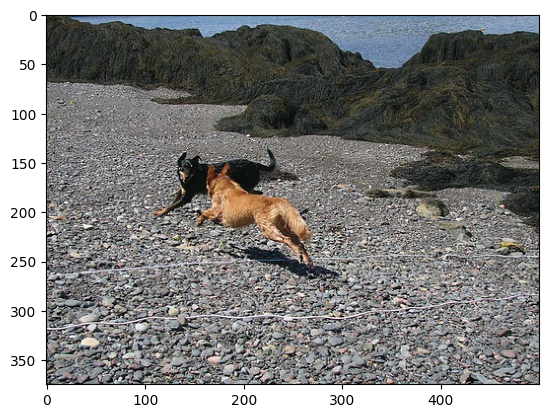

In [31]:
generate_caption("1056873310_49c665eb22.jpg")

---------------------Actual---------------------
start little girl covered in paint sits in front of painted rainbow with her hands in bowl end
start little girl is sitting in front of large painted rainbow end
start small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it end
start there is girl with pigtails sitting in front of rainbow painting end
start young girl with pigtails painting outside in the grass end
--------------------Predicted--------------------
start little girl in red dress lays on the ground end


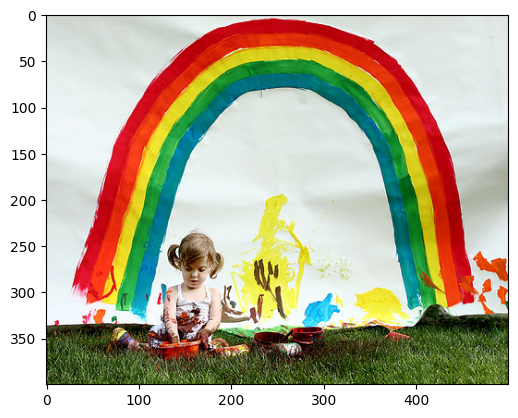

In [32]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
start man in hat is displaying pictures next to skier in blue hat end
start man skis past another man displaying paintings in the snow end
start person wearing skis looking at framed pictures set up in the snow end
start skier looks at framed pictures in the snow next to trees end
start man on skis looking at artwork for sale in the snow end
--------------------Predicted--------------------
start man in black coat and red coat is displaying pictures of snow end


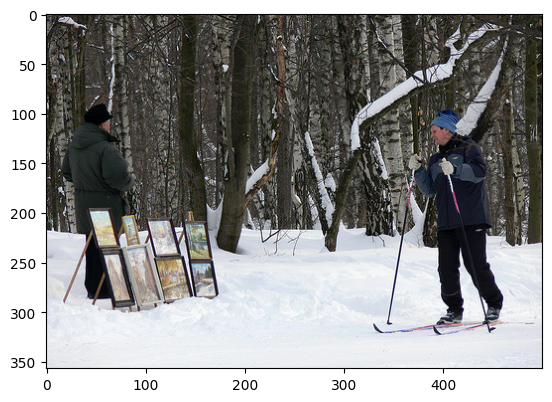

In [33]:
generate_caption("101669240_b2d3e7f17b.jpg")

---------------------Actual---------------------
start couple of several people sitting on ledge overlooking the beach end
start group of people sit on wall at the beach end
start group of teens sit on wall by beach end
start crowd of people at the beach end
start several young people sitting on rail above crowded beach end
--------------------Predicted--------------------
start two people are walking on the beach end


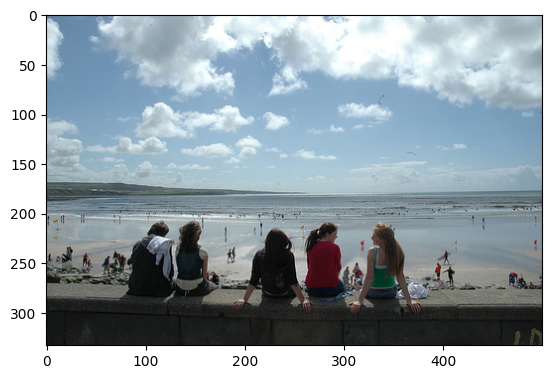

In [34]:
generate_caption("1048710776_bb5b0a5c7c.jpg")

---------------------Actual---------------------
start child and woman are at waters edge in big city end
start large lake with lone duck swimming in it with several people around the edge of it end
start little boy at lake watching duck end
start young boy waves his hand at the duck in the water surrounded by green park end
start "two people are at the edge of lake facing the water and the city skyline ." end
--------------------Predicted--------------------
start man and woman are playing in lake end


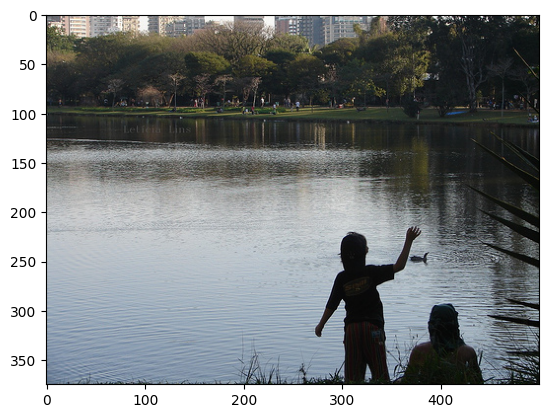

In [35]:
generate_caption('1022454332_6af2c1449a.jpg')